## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import sys
import os

py_file_location = "/content/gdrive/MyDrive/Reinforcement Learning/Tic Tac Toe Assignment"
sys.path.append(os.path.abspath(py_file_location))

In [3]:
from TCGame_Env1 import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [4]:
env = TicTacToe()

In [5]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
  return ('-'.join(str(e) for e in state)).replace('nan','x')

In [6]:
Q_state(env.state)

'x-x-x-x-x-x-x-x-x'

In [7]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [8]:
valid_actions(env.state)

[(0, 1),
 (0, 3),
 (0, 5),
 (0, 7),
 (0, 9),
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 9),
 (2, 1),
 (2, 3),
 (2, 5),
 (2, 7),
 (2, 9),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 7),
 (3, 9),
 (4, 1),
 (4, 3),
 (4, 5),
 (4, 7),
 (4, 9),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 7),
 (5, 9),
 (6, 1),
 (6, 3),
 (6, 5),
 (6, 7),
 (6, 9),
 (7, 1),
 (7, 3),
 (7, 5),
 (7, 7),
 (7, 9),
 (8, 1),
 (8, 3),
 (8, 5),
 (8, 7),
 (8, 9)]

In [9]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [10]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    #epsilon = - 1/(1 + np.exp((-time+7500000)/1700000)) + 1
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay*time)
    z = np.random.random()
    if z > epsilon:
      state_q = Q_state(state)
      action = max(Q_dict[state_q],key=Q_dict[state_q].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
      agent_action, env_action = env.action_space(state)
      action = random.choice([i for i in agent_action])    #Exploration: randomly choosing and action
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [11]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [12]:
# Initialise states to be tracked
def initialise_tracking_states():
  sample_q_values = [('x-x-x-x-x-x-x-x-x',(1,5)),('x-x-x-x-x-3-x-x-x',(3,7)),('4-x-6-x-x-x-x-x-x',(4,3)),('x-1-6-x-8-x-3-x-x',(8,5))]    #select any 4 Q-values
  for q_values in sample_q_values:
    state = q_values[0]
    action = q_values[1]
    States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 3000th episode         

In [13]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open('/content/gdrive/MyDrive/Reinforcement Learning/Tic Tac Toe Assignment/'+name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [14]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [15]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [16]:
EPISODES = 15000000        #No. of episodes
LR = 0.01                  #learning rate
GAMMA = 0.9                #discount factor
decay = 0.000001           #decay rate 
max_epsilon = 1.0          #For epsilon-greedy function - to calculate epsilon
min_epsilon = 0.001        #For epsilon-greedy function - to calculate epsilon
threshold = 2000           #every 2000 episodes, the 4 Q-values will be stored/appended (convergence graphs)
policy_threshold = 30000   #every 30,000 episodes, the Q-dict will be updated

### Q-update loop ---write your code here

In [17]:
start_time = time.time()

for episode in range(EPISODES):
##### Start writing your code from the next line
  env = TicTacToe()
  initial_state = env.state
  curr_state = env.state
  terminal = False
  add_to_dict(curr_state)
  reward = 0
  tot_reward = 0

  while terminal==False:
    curr_state_q = Q_state(curr_state)
    curr_action = epsilon_greedy(curr_state,episode)
    next_state, reward, terminal = env.step(curr_state, curr_action)
    next_state_q = Q_state(next_state)
    add_to_dict(next_state)

    if terminal==False:
      # UPDATE RULE
      max_next = max(Q_dict[next_state_q],key=Q_dict[next_state_q].get)   #this gets the action corresponding to max q-value of next state
      Q_dict[curr_state_q][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_q][max_next]))) - Q_dict[curr_state_q][curr_action]) 
    else:
      Q_dict[curr_state_q][curr_action] += LR * ((reward - Q_dict[curr_state_q][curr_action]))    #Discount factor is not required if terminal state is reached
    curr_state = next_state       #As we move ahead, the next state now becomes the current state 

    tot_reward += reward

  #TRACKING Q-VALUES
  if (episode == threshold-1):        #at the 1999th episode
    initialise_tracking_states()
      
  if ((episode+1) % threshold) == 0:   #every 2000th episode
    save_tracking_states()
    save_obj(States_track,'States_tracked')   
    
  #SAVING POLICY
  if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
    save_obj(Q_dict,'Policy')

elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

In [18]:
print("Hours Taken: "+str(round(elapsed_time/3600,2)))

Hours Taken: 3.91


#### Check the Q-dictionary

In [ ]:
Q_dict

In [20]:
len(Q_dict)

2277193

#### Check the states tracked for Q-values convergence
(non-evaluative)

<function matplotlib.pyplot.show>

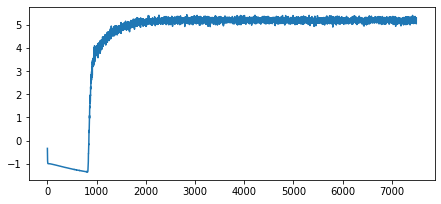

In [31]:
plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,5)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,5)]))
plt.show

### Epsilon - decay check

In [24]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

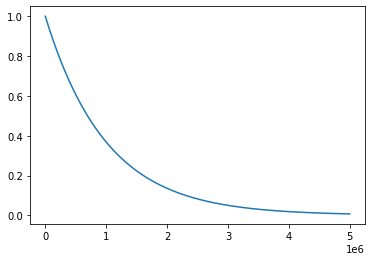

In [25]:
plt.plot(time, epsilon)
plt.show()